# This notebook includes weights both with and without fine tuning on morph datasets

In [1]:
gpus = [1]
import os
os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(i) for i in gpus])

In [2]:
import tensorflow as tf
# tf.enable_eager_execution()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from glob import glob
import pickle
from tensorflow.keras import layers, Sequential, datasets, models, losses, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import datetime
import sys
from tensorflow.keras.backend import clear_session
from trainingfuncs import *
from math_utils import *
from scipy.spatial import distance
import seaborn as sns

In [3]:
sys.path.append("..") # Adds higher directory to python modules path.
from helpers.dataset_vars import *
from helpers.myclasses import *

In [4]:
morph_folder = os.path.abspath('/mnt/cube/kai/repositories/morphs/data/stimuli')

results_folder = os.path.abspath('/mnt/cube/kai/results/sound_texture/classifier')
spec_file = os.path.join(morph_folder, 'specs_star.p')

In [5]:
spec_df = pickle.load(open(spec_file, 'rb'))

In [6]:
stim_cats = spec_df.stim.unique().tolist()

In [7]:
spec_list = spec_df.spec.values.tolist()

In [8]:
h, w = spec_list[0].shape

In [9]:
print(h, w)

298 76


## make model and load weights

In [10]:
clear_session()

In [11]:
model=self_VGG()

In [12]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [13]:
model_inputs = Input(shape=(h, w, 3))
resized = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear")(model_inputs)
model_outputs = model(resized)
feature_extractor = Model(model_inputs, model_outputs)

# First without fine tuning

In [14]:
weights_file = os.path.abspath('/mnt/cube/kai/results/perceptual_loss/2021_10_14_10_55_07/weights-improvement.h5')
feature_extractor.load_weights(weights_file, by_name=True)

## extract feature vector from each morph

In [15]:
cat_list = []
id_list = []
feature_rmse_list = []
feature_cosine_list = []
spec_rmse_list = []

for cat in stim_cats:
    cat_specs = spec_df[spec_df.stim==cat].reset_index(drop=True)
    
    # init value
    init_spec = cat_specs[cat_specs.id==1].spec.values[0]
    init_spec_3d = np.stack([init_spec, init_spec, init_spec], axis = 2)
    init_features = np.squeeze(feature_extractor.predict(np.expand_dims(init_spec_3d, axis=0)))
    
    # iterate through morphs
    for _, spec_i, _, spec in cat_specs.values:
        spec_3d = np.stack([spec, spec, spec], axis = 2)

        spec_features = np.squeeze(feature_extractor.predict(np.expand_dims(spec_3d, axis=0)))
        
        cat_list.append(cat)
        id_list.append(spec_i)
        feature_rmse_list.append(rmse(init_features, spec_features))
        feature_cosine_list.append(distance.cosine(init_features, spec_features))
        spec_rmse_list.append(rmse(init_spec_3d, spec_3d))

    paragraph_print(f'Done with {cat}', separation='*')

Done with ac
**************************************************
Done with ad
**************************************************
Done with ae
**************************************************
Done with af
**************************************************
Done with ag
**************************************************
Done with ah
**************************************************
Done with bc
**************************************************
Done with bd
**************************************************
Done with be
**************************************************
Done with bf
**************************************************
Done with bg
**************************************************
Done with bh
**************************************************
Done with ce
**************************************************
Done with cf
**************************************************
Done with cg
**************************************************
Done with ch
***************************

In [16]:
morph_df = pd.DataFrame()
morph_df['morph_dim'] = cat_list
morph_df['id'] = id_list
morph_df['feature_rmse'] = feature_rmse_list
morph_df['feature_cosine'] = feature_cosine_list
morph_df['spec_rmse'] = spec_rmse_list

In [34]:
morph_df.to_pickle(os.path.join('/mnt/cube/kai/results/perceptual_loss/2021_10_14_10_55_07', 'morph_singlesided.p'))

# inspect example morph dim

In [17]:
morph_dim = 'ae'

In [18]:
reduced_morph_df = morph_df[morph_df.morph_dim==morph_dim].reset_index(drop=True)

<AxesSubplot:xlabel='id', ylabel='spec_rmse'>

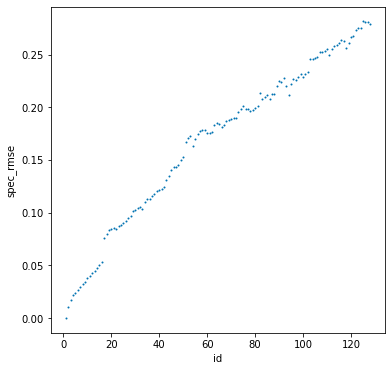

In [19]:
fig = plt.figure(figsize=(6,6))
sns.scatterplot(data=reduced_morph_df, x='id', y='spec_rmse', 
                s = 4, linewidth = 0)

<AxesSubplot:xlabel='id', ylabel='feature_rmse'>

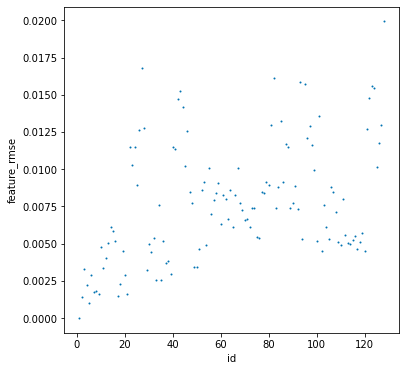

In [20]:
fig = plt.figure(figsize=(6,6))
sns.scatterplot(data=reduced_morph_df, x='id', y='feature_rmse', 
                s = 4, linewidth = 0)

# see all morph dims

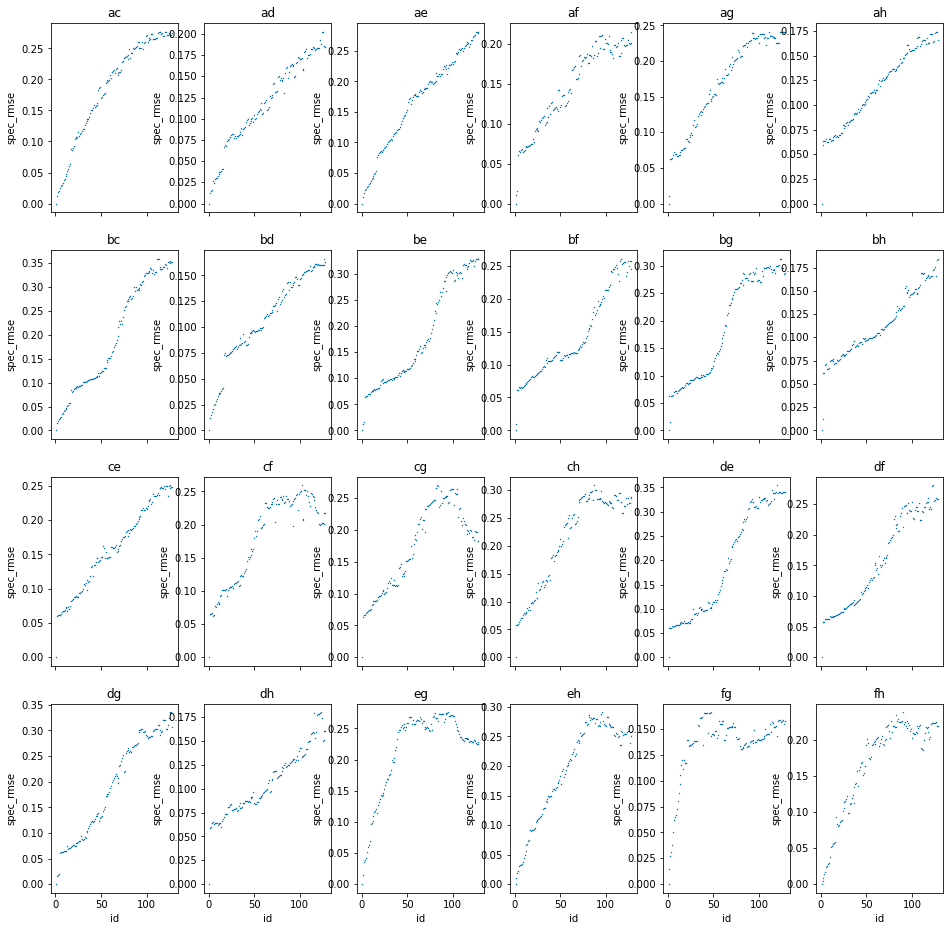

In [21]:
fig, ax = plt.subplots(4, 6, figsize=(16,16), sharex=True)
for i, morph_dim in enumerate(stim_cats):
    reduced_morph_df = morph_df[morph_df.morph_dim==morph_dim].reset_index(drop=True)
    row = i//6
    col = i%6
    sns.scatterplot(data=reduced_morph_df, x='id', y='spec_rmse', 
                s = 2, linewidth = 0, ax=ax[row][col])
    ax[row][col].set_title(morph_dim)

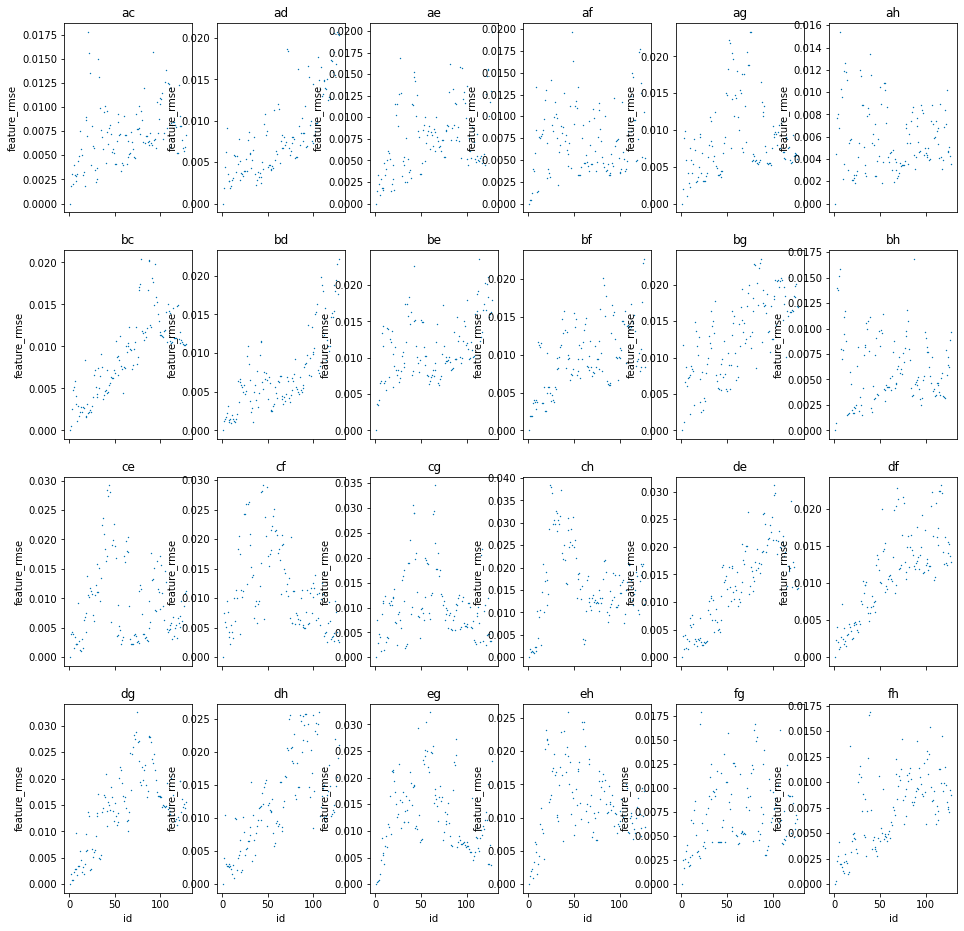

In [22]:
fig, ax = plt.subplots(4, 6, figsize=(16,16), sharex=True)
for i, morph_dim in enumerate(stim_cats):
    reduced_morph_df = morph_df[morph_df.morph_dim==morph_dim].reset_index(drop=True)
    row = i//6
    col = i%6
    sns.scatterplot(data=reduced_morph_df, x='id', y='feature_rmse', 
                s = 2, linewidth = 0, ax=ax[row][col])
    ax[row][col].set_title(morph_dim)

In [23]:
row_dict = {'a':0, 'b':1, 'c':2, 'd':3, 'e':4, 'f':5}
col_dict = {'c':0, 'd':1, 'e':2, 'f':3, 'g':4, 'h':5}

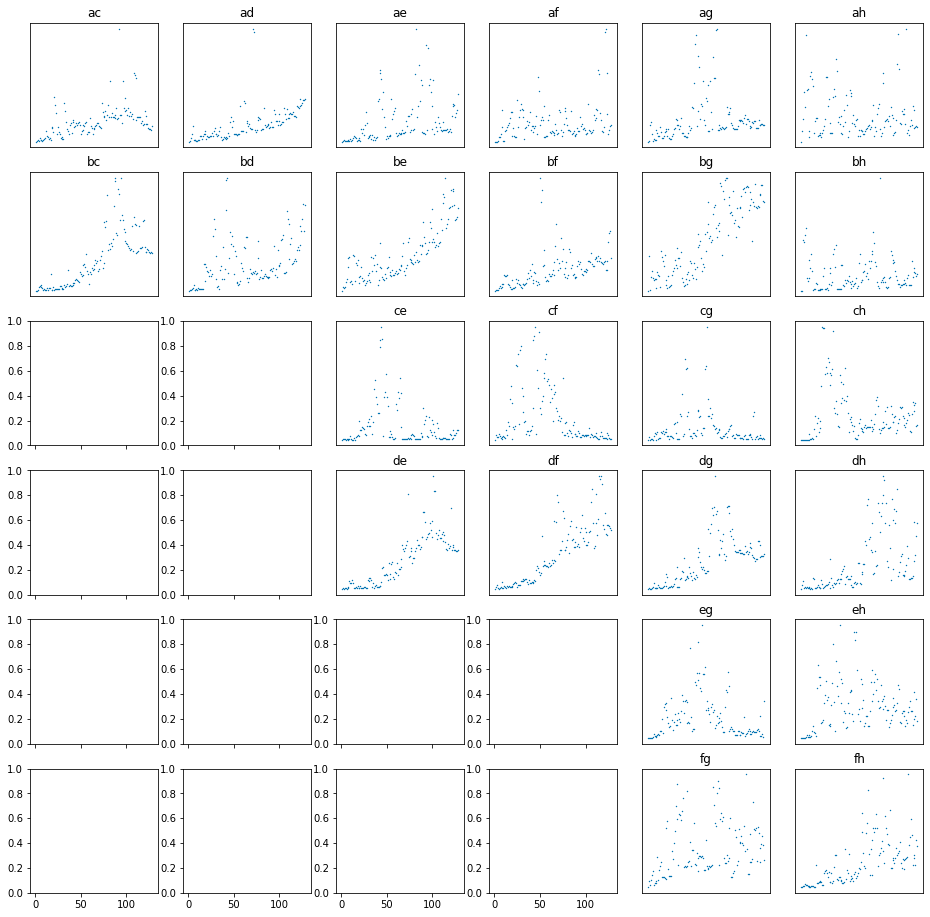

In [24]:
fig, ax = plt.subplots(6, 6, figsize=(16,16), sharex=True)
for morph_dim in stim_cats:
    reduced_morph_df = morph_df[morph_df.morph_dim==morph_dim].reset_index(drop=True)
    row = row_dict[morph_dim[0]]
    col = col_dict[morph_dim[1]]
    sns.scatterplot(data=reduced_morph_df, x='id', y='feature_cosine', 
                s = 2, linewidth = 0, ax=ax[row][col])
    ax[row][col].set_title(morph_dim)
    ax[row][col].get_xaxis().set_visible(False)
    ax[row][col].get_yaxis().set_visible(False)


# if I make this symmetrical
define distance as the min between initial and final spec

In [25]:
cat_list = []
id_list = []
feature_rmse_list = []
feature_cosine_list = []
spec_rmse_list = []
less_dim_list = []
more_dim_list = []

for cat in stim_cats:
    cat_specs = spec_df[spec_df.stim==cat].reset_index(drop=True)
    
    # init value
    init_spec = cat_specs[cat_specs.id==1].spec.values[0]
    init_spec_3d = np.stack([init_spec, init_spec, init_spec], axis = 2)
    init_features = np.squeeze(feature_extractor.predict(np.expand_dims(init_spec_3d, axis=0)))
    
    # last value
    final_spec = cat_specs[cat_specs.id==128].spec.values[0]
    final_spec_3d = np.stack([final_spec, final_spec, final_spec], axis = 2)
    final_features = np.squeeze(feature_extractor.predict(np.expand_dims(final_spec_3d, axis=0)))
    
    # diff
    max_feature_rmse = rmse(init_features, final_features)
    max_feature_cosine = distance.cosine(init_features, final_features)
    max_spec_rmse = rmse(init_spec_3d, final_spec_3d)
    
    # iterate through morphs
    for _, spec_i, _, spec in cat_specs.values:
        spec_3d = np.stack([spec, spec, spec], axis = 2)

        spec_features = np.squeeze(feature_extractor.predict(np.expand_dims(spec_3d, axis=0)))
        
        init_feature_rmse = rmse(init_features, spec_features)
        final_feature_rmse = rmse(final_features, spec_features)
        init_feature_cosine = distance.cosine(init_features, spec_features)
        final_feature_cosine = distance.cosine(final_features, spec_features)
        init_spec_rmse = rmse(init_spec_3d, spec_3d)
        final_spec_rmse = rmse(final_spec_3d, spec_3d)
        
#         if init_feature_rmse>final_feature_rmse:
#             feature_rmse = max_feature_rmse-final_feature_rmse
#         else:
#             feature_rmse = init_feature_rmse
        
#         if init_feature_cosine>final_feature_cosine:
#             feature_cosine = max_feature_cosine-final_feature_cosine
#         else:
#             feature_cosine = init_feature_cosine
        
#         if init_spec_rmse>final_spec_rmse:
#             spec_rmse = max_spec_rmse-final_spec_rmse
#         else:
#             spec_rmse = init_spec_rmse
        
        feature_rmse = (max_feature_rmse-final_feature_rmse+init_feature_rmse)/2
        feature_cosine = (max_feature_cosine-final_feature_cosine+init_feature_cosine)/2
        spec_rmse = (max_spec_rmse-final_spec_rmse+init_spec_rmse)/2
        
        cat_list.append(cat)
        less_dim_list.append(cat[0])
        more_dim_list.append(cat[1])
        id_list.append(spec_i)
        
        feature_rmse_list.append(feature_rmse)
        feature_cosine_list.append(feature_cosine)
        spec_rmse_list.append(spec_rmse)

    paragraph_print(f'Done with {cat}', separation='*')

Done with ac
**************************************************
Done with ad
**************************************************
Done with ae
**************************************************
Done with af
**************************************************
Done with ag
**************************************************
Done with ah
**************************************************
Done with bc
**************************************************
Done with bd
**************************************************
Done with be
**************************************************
Done with bf
**************************************************
Done with bg
**************************************************
Done with bh
**************************************************
Done with ce
**************************************************
Done with cf
**************************************************
Done with cg
**************************************************
Done with ch
***************************

In [26]:
morph_df_sym = pd.DataFrame()
morph_df_sym['morph_dim'] = cat_list
morph_df_sym['id'] = id_list
morph_df_sym['lesser_dim'] = less_dim_list
morph_df_sym['greater_dim'] = more_dim_list
morph_df_sym['feature_rmse'] = feature_rmse_list
morph_df_sym['feature_cosine'] = feature_cosine_list
morph_df_sym['spec_rmse'] = spec_rmse_list

In [35]:
morph_df_sym.to_pickle(os.path.join('/mnt/cube/kai/results/perceptual_loss/2021_10_14_10_55_07', 'morph_doublesided.p'))

# see all morph dims

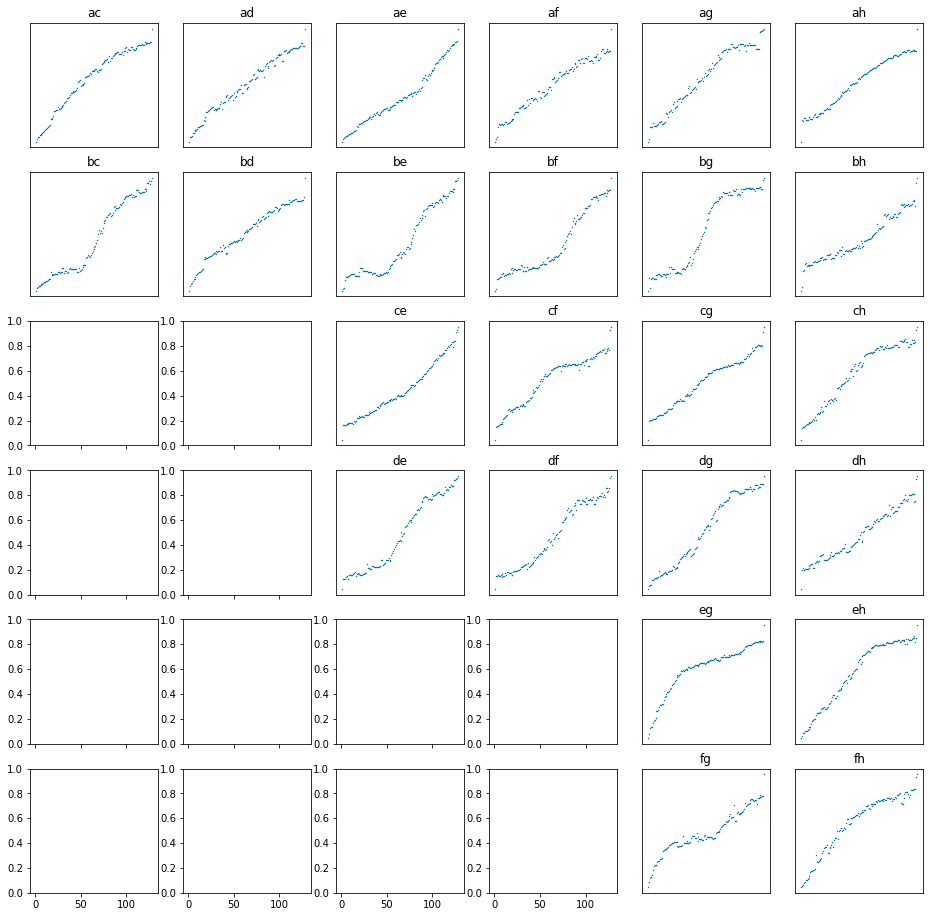

In [27]:
fig, ax = plt.subplots(6, 6, figsize=(16,16), sharex=True)
for morph_dim in stim_cats:
    reduced_morph_df = morph_df_sym[morph_df_sym.morph_dim==morph_dim].reset_index(drop=True)
    row = row_dict[morph_dim[0]]
    col = col_dict[morph_dim[1]]
    sns.scatterplot(data=reduced_morph_df, x='id', y='spec_rmse', 
                s = 2, linewidth = 0, ax=ax[row][col])
    ax[row][col].set_title(morph_dim)
    ax[row][col].get_xaxis().set_visible(False)
    ax[row][col].get_yaxis().set_visible(False)


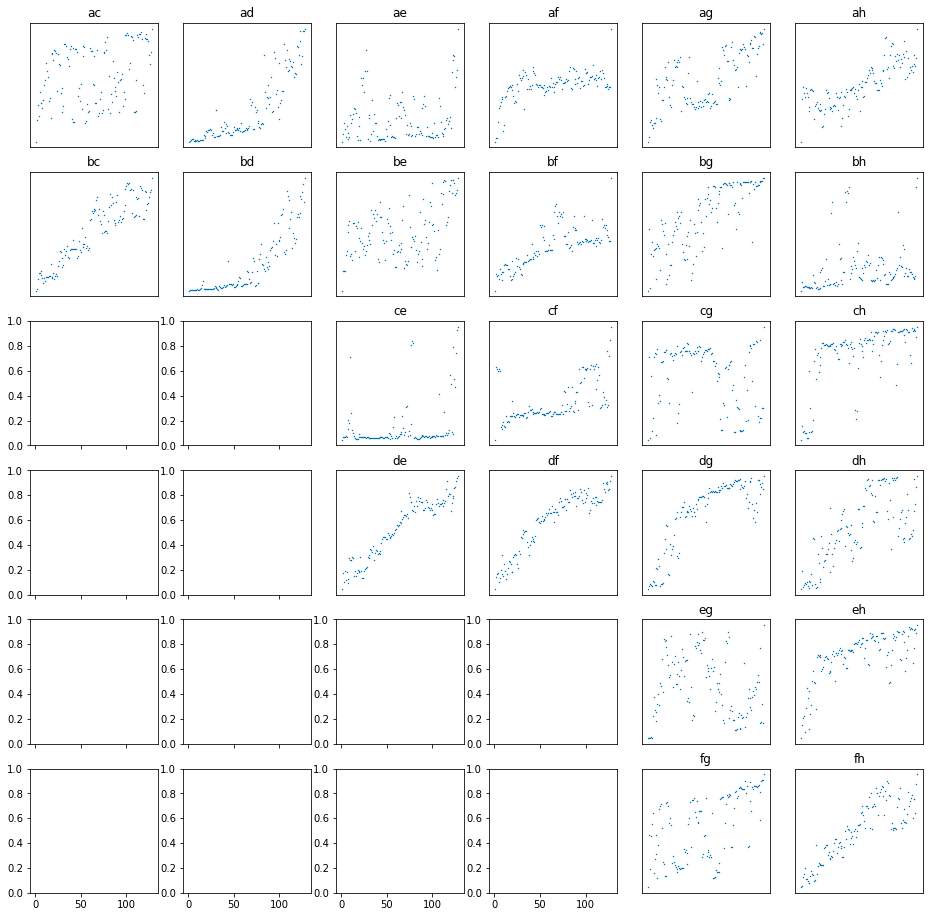

In [28]:
fig, ax = plt.subplots(6, 6, figsize=(16,16), sharex=True)
for morph_dim in stim_cats:
    reduced_morph_df = morph_df_sym[morph_df_sym.morph_dim==morph_dim].reset_index(drop=True)
    row = row_dict[morph_dim[0]]
    col = col_dict[morph_dim[1]]
    sns.scatterplot(data=reduced_morph_df, x='id', y='feature_rmse', 
                s = 2, linewidth = 0, ax=ax[row][col])
    ax[row][col].set_title(morph_dim)
    ax[row][col].get_xaxis().set_visible(False)
    ax[row][col].get_yaxis().set_visible(False)


In [29]:
row_dict = {'a':0, 'b':1, 'c':2, 'd':3, 'e':4, 'f':5}
col_dict = {'c':0, 'd':1, 'e':2, 'f':3, 'g':4, 'h':5}

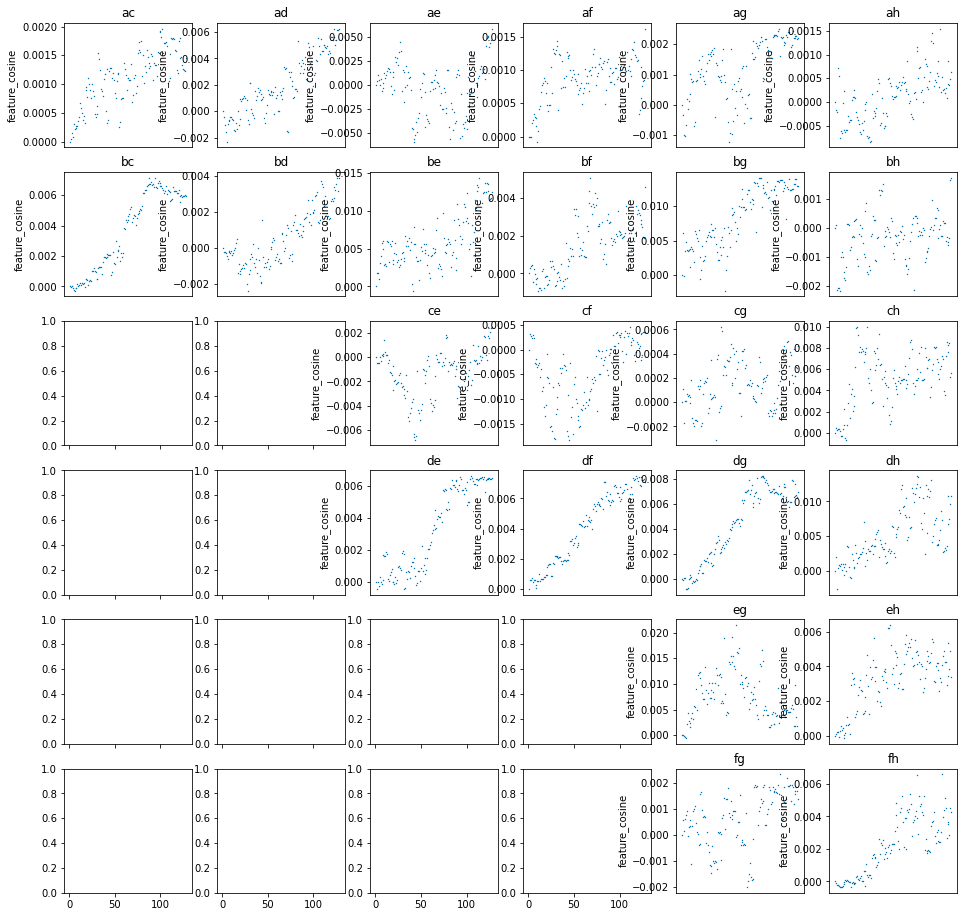

In [30]:
fig, ax = plt.subplots(6, 6, figsize=(16,16), sharex=True)
for morph_dim in stim_cats:
    reduced_morph_df = morph_df_sym[morph_df_sym.morph_dim==morph_dim].reset_index(drop=True)
    row = row_dict[morph_dim[0]]
    col = col_dict[morph_dim[1]]
    sns.scatterplot(data=reduced_morph_df, x='id', y='feature_cosine', 
                s = 2, linewidth = 0, ax=ax[row][col])
    ax[row][col].set_title(morph_dim)
    ax[row][col].get_xaxis().set_visible(False)
#     ax[row][col].get_yaxis().set_visible(False)
